# Case Innovation - People Analytics
### Danilo Pedrelli

## Sumário

1. [Introdução](#introducao)
1. [Entendimento do problema](#problema)
    1. [Dicionário de dados](#dicionario)
1. [Bibliotecas](#bibliotecas)
1. [Carregando dados](#dados)
1. [Descrição dos dados](#descricao)
1. [Análise exploratória de dados](#eda)
    1. [Análise univariada](#univariada)
    1. [Análise bivariada](#bivariada)
        1. [Correlação](#correlacao)
        1. [Gráficos](#graficos)
        1. [Attrition](#attrition)
1. [Modelagem](#modelagem)
    1. [Pré-processamento](#)
    1. [Testando modelos](modelos#)
    1. [Seleção de variáveis](#selecao)
    1. [Importância das variáveis](#importancia)
    1. [GridSearch](#gridsearch)
    1. [Métricas](#metricas)
    1. [Distribuição](#distribuicao)
    1. [Grupos de risco](#risco)
    1. [Explicabilidade do modelo](#explicabilidade)
1. [Conclusão](#conclusao)

<a id='introducao'></a>

## 1. Introdução

De acordo com o site da [Gupy](https://www.gupy.io/blog/people-analytics), uma das maiores empresas recrutamento do Brasil, People Analytics define-se como:

"*... a abordagem orientada a dados que coleta, organiza e diagnostica dados sobre as equipes da empresa por meio de softwares que cruzam as informações de diversas fontes — Tudo para otimizar o gerenciamento de Recursos Humanos.*"

Nesse sentido, iremos analisar um conjunto de dados de uma empresa, onde o nosso alvo é entender por que funcionários pedem demissão ("Attrition"), quais fatores e características impactam nessa decisão, e como melhorar para evitar que isso aconteça.

Esses dados na verdade foram gerados pela IBM e disponibilizados na plataforma do [Kaggle](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset), e são fictícios, mas servem para excelente entendimento dos problema que a área de People Analytics tem de lidar.

<a id='problema'></a>

## 2. Entendimento do problema

Quando funcionários pedem demissão, isso significa que estão insatisfeitos com a empresa, ou encontraram melhores oportunidades em outros lugares. Essa saída de funcionários é algo que pode afetar o desempenho de setores dentro da empresa, pois a fase de contratação leva tempo e custos para ser realizada. Através de dados de satisfação, envolvimento com o trabalho, performance, entre outros, espera-se obter uma análise que indique os fatores que podem causa essa decisão por parte dos funcionários, e um modelo capaz de predizer a probabilidade de determinado funcionários sair.

<a id='dicionario'></a>

### A. Dicionário de dados

Como mencionado, a presente base de dados foi retirada de um dataset do Kaggle. Para melhor interpretação, retirei do dataset o conjunto de significado das seguintes categorias:

__Education__ - 1: 'Below College', 2: 'College', 3: 'Bachelor', 4: 'Master', 5: 'Doctor'

__EnvironmentSatisfaction__ - 1: 'Low', 2: 'Medium', 3: 'High' , 4: 'Very High'

__JobInvolvement__ - 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'

__JobSatisfaction__ - 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'

__PerformanceRating__ 1: 'Low', 2: 'Good', 3: 'Excellent', 4: 'Outstanding'

__RelationshipSatisfaction__ 1: 'Low', 2: 'Medium', 3: 'High', 4: 'Very High'

__WorkLifeBalance__ 1: 'Bad', 2: 'Good', 3: 'Better', 4: 'Best'

<a id='bibliotecas'></a>

## 3. Bibliotecas

De início, importamos as bibliotecas necessárias para o projeto.

In [140]:
# Manipulação de dados

import pandas as pd # Pacote para visualização de dados em tabela
import numpy as np # Pacote para manipulação de dados

#Análise

import phik # Pacote de cálculo de correlação não-linear e variáveis categóricas

# Visualização

import seaborn as sns # Pacote de visualização
import matplotlib.pyplot as plt # Pacote de visualização

# Preprocessamento

from sklearn.compose import ColumnTransformer # Transformação de dados
from sklearn.preprocessing import StandardScaler,MinMaxScaler, OneHotEncoder, RobustScaler # Normalização e enconding
from sklearn.model_selection import train_test_split #Divisão de treino e teste
from sklearn.feature_selection import RFECV # Seleção recursiva de features

#Modelagem

from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.linear_model import LogisticRegression # Logistic Regression
import lightgbm as lgb # Light GBM
from sklearn.naive_bayes import GaussianNB #Naive Bayes
from sklearn.tree import DecisionTreeClassifier # Decision Tree

# Métricas

from sklearn.metrics import roc_auc_score, recall_score, precision_score, f1_score,\
confusion_matrix, classification_report, auc, roc_curve, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Optimização
from sklearn.model_selection import GridSearchCV

# Configuração

pd.set_option('display.max_columns',1000) # Define número máximo de colunas visualizadas no DataFrame
plt.rcParams.update({'font.size': 14})
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Após esta importação de bibliotecas, seguimos para a carregamento dos dados.

<a id='dados'></a>

## 4. Carregando Dados

Para importarmos os dados utilizamos o pandas, que possui uma função de leitura de documentos excel, "read_excel":

In [9]:
df = pd.read_excel('Dataset.xlsx')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


Para melhorar a avaliação da satisfação, iremos criar duas colunas, com a máxima satisfação e a mínima satisfação, em qualquer área, seja ela relacionamento, ambiente ou trabalho:

In [10]:
sats_cols = ['JobSatisfaction','EnvironmentSatisfaction','RelationshipSatisfaction']
df['MinSatisfaction'] = df[sats_cols].T.min()
df['MaxSatisfaction'] = df[sats_cols].T.max()
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,MinSatisfaction,MaxSatisfaction
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5,1,4
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7,2,4
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0,2,4
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0,3,4
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2,1,4


Para melhor descrição dos dados, iremos substituir as variáveis categóricas, representadas por números, pelos seus devidos significados:

In [11]:
df['Education'] = df['Education'].replace([1,2,3,4,5],['Below College', 'College', 'Bachelor', 'Master', 'Doctor'])
df['EnvironmentSatisfaction'] = df['EnvironmentSatisfaction'].replace([1,2,3,4],['Low', 'Medium', 'High', 'Very High'])
df['JobInvolvement'] = df['JobInvolvement'].replace([1,2,3,4],['Low', 'Medium', 'High', 'Very High'])
df['JobSatisfaction'] = df['JobSatisfaction'].replace([1,2,3,4],['Low', 'Medium', 'High', 'Very High'])
df['PerformanceRating'] = df['PerformanceRating'].replace([1,2,3,4],['Low', 'Good', 'Excellent', 'Outstanding'])
df['RelationshipSatisfaction'] = df['RelationshipSatisfaction'].replace([1,2,3,4],['Low', 'Medium', 'High', 'Very High'])
df['WorkLifeBalance'] = df['WorkLifeBalance'].replace([1,2,3,4],['Bad', 'Good', 'Better', 'Best'])
df['MinSatisfaction'] = df['MinSatisfaction'].replace([1,2,3,4],['Low', 'Medium', 'High', 'Very High'])
df['MaxSatisfaction'] = df['MaxSatisfaction'].replace([1,2,3,4],['Low', 'Medium', 'High', 'Very High'])

Em seguida, realizamos uma descrição dos dados a fim de já obter uma visão geral dos dados.

<a id='descricao'></a>

## 5. Descrição dos dados

Primeiramente coletamos informações sobre os dados.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 37 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   object
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   object
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   object
 14  JobLevel                

Para identificar as variáveis categóricas fazemos:

In [13]:
categoricas = []
for x in df.columns:
    if df[x].dtype=='object':
        print(x)
        categoricas.append(x)

print('\nO número de variáveis categoricas é:',len(categoricas))

Attrition
BusinessTravel
Department
Education
EducationField
EnvironmentSatisfaction
Gender
JobInvolvement
JobRole
JobSatisfaction
MaritalStatus
Over18
OverTime
PerformanceRating
RelationshipSatisfaction
WorkLifeBalance
MinSatisfaction
MaxSatisfaction

O número de variáveis categoricas é: 18


Das 35 variáveis, 18 são categóricas e as demais são numéricas. Aqui podemos ver que os dados estão bem organizados e não possuem valores ausentes, pois tanto o dataframe quanto as variáveis possuem 1470 entradas. Mas para verificar isso, contaremos os valores ausentes:

In [14]:
print('O número de valores ausentes em todo o DataFrame é',df.isna().sum().sum())

O número de valores ausentes em todo o DataFrame é 0


Realmente, não há valores ausentes no dataframe. Para ter uma visão estatística das variáveis, iremos calcular a descrição das mesmas, tanto para as numéricas quanto para as categóricas, conforme segue abaixo:

__Variáveis Numéricas__

In [15]:
df.describe()

,Age,DailyRate,DistanceFromHome,EmployeeCount,EmployeeNumber,HourlyRate,JobLevel,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,1.0,1024.865306,65.891156,2.063946,6502.931293,14313.103401,2.693197,15.209524,80.0,0.793878,11.279592,2.799320,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,0.0,602.024335,20.329428,1.106940,4707.956783,7117.786044,2.498009,3.659938,0.0,0.852077,7.780782,1.289271,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.0,1.000000,30.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,80.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,1.0,491.250000,48.000000,1.000000,2911.000000,8047.000000,1.000000,12.000000,80.0,0.000000,6.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,1.0,1020.500000,66.000000,2.000000,4919.000000,14235.500000,2.000000,14.000000,80.0,1.000000,10.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,1.0,1555.750000,83.750000,3.000000,8379.000000,20461.500000,4.000000,18.000000,80.0,1.000000,15.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,1.0,2068.000000,100.000000,5.000000,19999.000000,26999.000000,9.000000,25.000000,80.0,3.000000,40.000000,6.000000,40.000000,18.000000,15.000000,17.000000


Aqui podemos verificar que "EmployeeCount" e "StandardHours" possuem entradas únicas, pois o desvio padrão das mesmas é 0, por isso iremos retirá-las do dataframe:

In [16]:
df.drop(['EmployeeCount','StandardHours'],axis=1,inplace=True)

 Também podemos tirar algumas conclusões:

- A média de idade dos funcionários é de 37 anos.
- O salário médio é de 6.500,00 (provavelmente em dólares), mas com desvio padrão de 4.700,00, o que significa dizer que há uma variação alta de salário.
- Na  média, as pessoas trabalham por 7 anos na empresa, mas temos bons outliers, pois existem funcionários que estão na empresa há 40 anos, por exemplo, enquanto outros não chegam a 1 ano.
- A última promoção é um variável importante, pois pode gerar satisfação e evitar saída do funcionário. Em média, faz 3 anos que os funcionários não recebem promoção, mas existem aqueles que chegam a 15 anos sem promoção.

Após análise das variáveis numéricas, seguimos para as categóricas.

__Variáveis Categóricas__

In [17]:
df[categoricas].describe()

,Attrition,BusinessTravel,Department,Education,EducationField,EnvironmentSatisfaction,Gender,JobInvolvement,JobRole,JobSatisfaction,MaritalStatus,Over18,OverTime,PerformanceRating,RelationshipSatisfaction,WorkLifeBalance,MinSatisfaction,MaxSatisfaction
count,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470,1470
unique,2,3,3,5,6,4,2,4,9,4,3,1,2,2,4,4,4,4
top,No,Travel_Rarely,Research & Development,Bachelor,Life Sciences,High,Male,High,Sales Executive,Very High,Married,Y,No,Excellent,High,Better,Low,Very High
freq,1233,1043,961,572,606,453,882,868,326,459,673,1470,1054,1244,459,893,700,978


Aqui percebemos que "Over18" somente possui uma única entrada, por conta disso, iremos remover do DataFrame,assim como 'EmployeeNumber', que é uma variável de identificação:

In [18]:
df.drop(['Over18','EmployeeNumber'],axis=1,inplace=True)

Algumas conclusões que podemos tirar são:

- "Attrition" é uma variável desbalanceada, com a maior parte dos funcionários permanecendo na empresa.
- Funcionários também não tendem a viajar muito, o que pode ser indicativo de algum fator de estresse.
- O setor de pesquisa é o maior na empresa, mostrando que a empresa provavelmente trabalha no ramo de inovação.
- A satisfação com o ambiente e relacionamento em sua grande parte é alta, com o trabalho é muito alta, o que é bom sinal.
- O balanço entre trabalho e vida é bom mas poderia melhorar, significando que esse pode ser um ponto a se trabalhar na empresa.

Uma vez feita essa descrição dos dados, seguimos para uma análise exploratória mais aprofundada.

<a id='eda'></a>

## 6. Análise Exploratória de Dados

<a id='univariada'></a>

### A. Análise univariada

Primeiramente, faremos uma análise exploratória univariada de algumas variáves, respondendo a algumas perguntas.

__Como anda a satisfação dos funcionários em relação ao trabalho, ambiente e relacionamento, assim como seu envolvimento com o trabalho?__

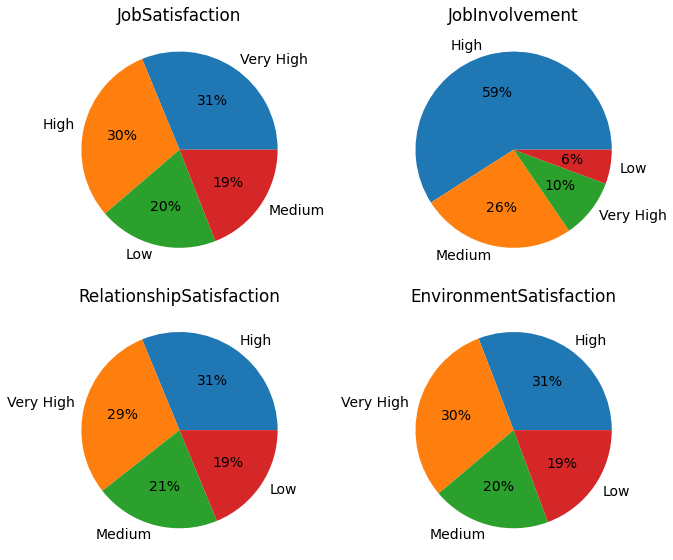

In [19]:
fig, ax = plt.subplots(nrows = 2, ncols=2, figsize = (10,8))

# JobSatisfaction
ax[0,0].pie(df['JobSatisfaction'].value_counts(normalize=True),labels=df['JobSatisfaction'].value_counts(normalize=True).index,
            autopct='%.0f%%')
ax[0,0].set_title('JobSatisfaction')
plt.savefig('teste.png')

# JobInvolvement
ax[0,1].pie(df['JobInvolvement'].value_counts(normalize=True),labels=df['JobInvolvement'].value_counts(normalize=True).index,
            autopct='%.0f%%')
ax[0,1].set_title('JobInvolvement')

# RelationshipSatisfaction
ax[1,0].pie(df['RelationshipSatisfaction'].value_counts(normalize=True),labels=df['RelationshipSatisfaction'].value_counts(normalize=True).index,
            autopct='%.0f%%')
ax[1,0].set_title('RelationshipSatisfaction')

# EnvironmentSatisfaction
ax[1,1].pie(df['EnvironmentSatisfaction'].value_counts(normalize=True),labels=df['EnvironmentSatisfaction'].value_counts(normalize=True).index,
            autopct='%.0f%%')
ax[1,1].set_title('EnvironmentSatisfaction')
plt.tight_layout()
plt.savefig('Satisfação_envolvimento.jpeg')
plt.show()

Também plotamos o score mínimo e máximo por categoria

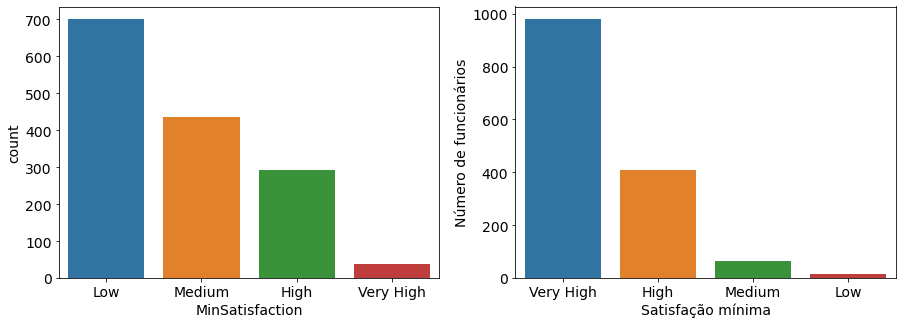

In [20]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(x='MinSatisfaction',data=df,ax=ax[0])
sns.countplot(x='MaxSatisfaction',data=df,ax=ax[1])
plt.ylabel('Número de funcionários')
plt.xlabel('Satisfação mínima')
plt.show()

As conclusões que podemos tirar dos gráficos acima são:

- O nível de satifação tanto com o trabalho quanto com o ambiente e relacionamento possui praticamente a mesma distribuição, o que pode mostrar a conexão entre essa variáveis para a empresa de modo geral. A porcentagem é praticamente igual entre as categorias, o que não é de fato um bom sinal, pois a satisfação baixa é de 19%, algo a se melhorar.

- Envolvimento com o trabalho tem valores muito bons, com 59 % sendo alto e 10% sendo muito alto.

- Dos 1470 funcionário, 700 estão insatisfeitos com algo na empresa, que é praticamente metade dos funcionários.

<a id='bivariada'></a>

### B. Análise bivariada dos dados

Inicialmente, para ter insights sobre a relação entre as variáveis, iremos plotar a correlação entre as variáveis.

<a id='correlacao'></a>

#### a. Correlação

Para entendermos a relação das variáveis entre si, faremos a correlação das mesmas. Para isso, utilizaremos a biblioteca "phik", que permite o cálculo de correlação não linear, assim como de variáveis categóricas utilizando o médoto $\chi^2$:

In [21]:
int_cols = ['Age', 'DailyRate', 'DistanceFromHome', 'HourlyRate', 'JobLevel', 'MonthlyIncome', 'MonthlyRate',
            'NumCompaniesWorked', 'PercentSalaryHike', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
            'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager']

corr = df.phik_matrix(interval_cols=int_cols)

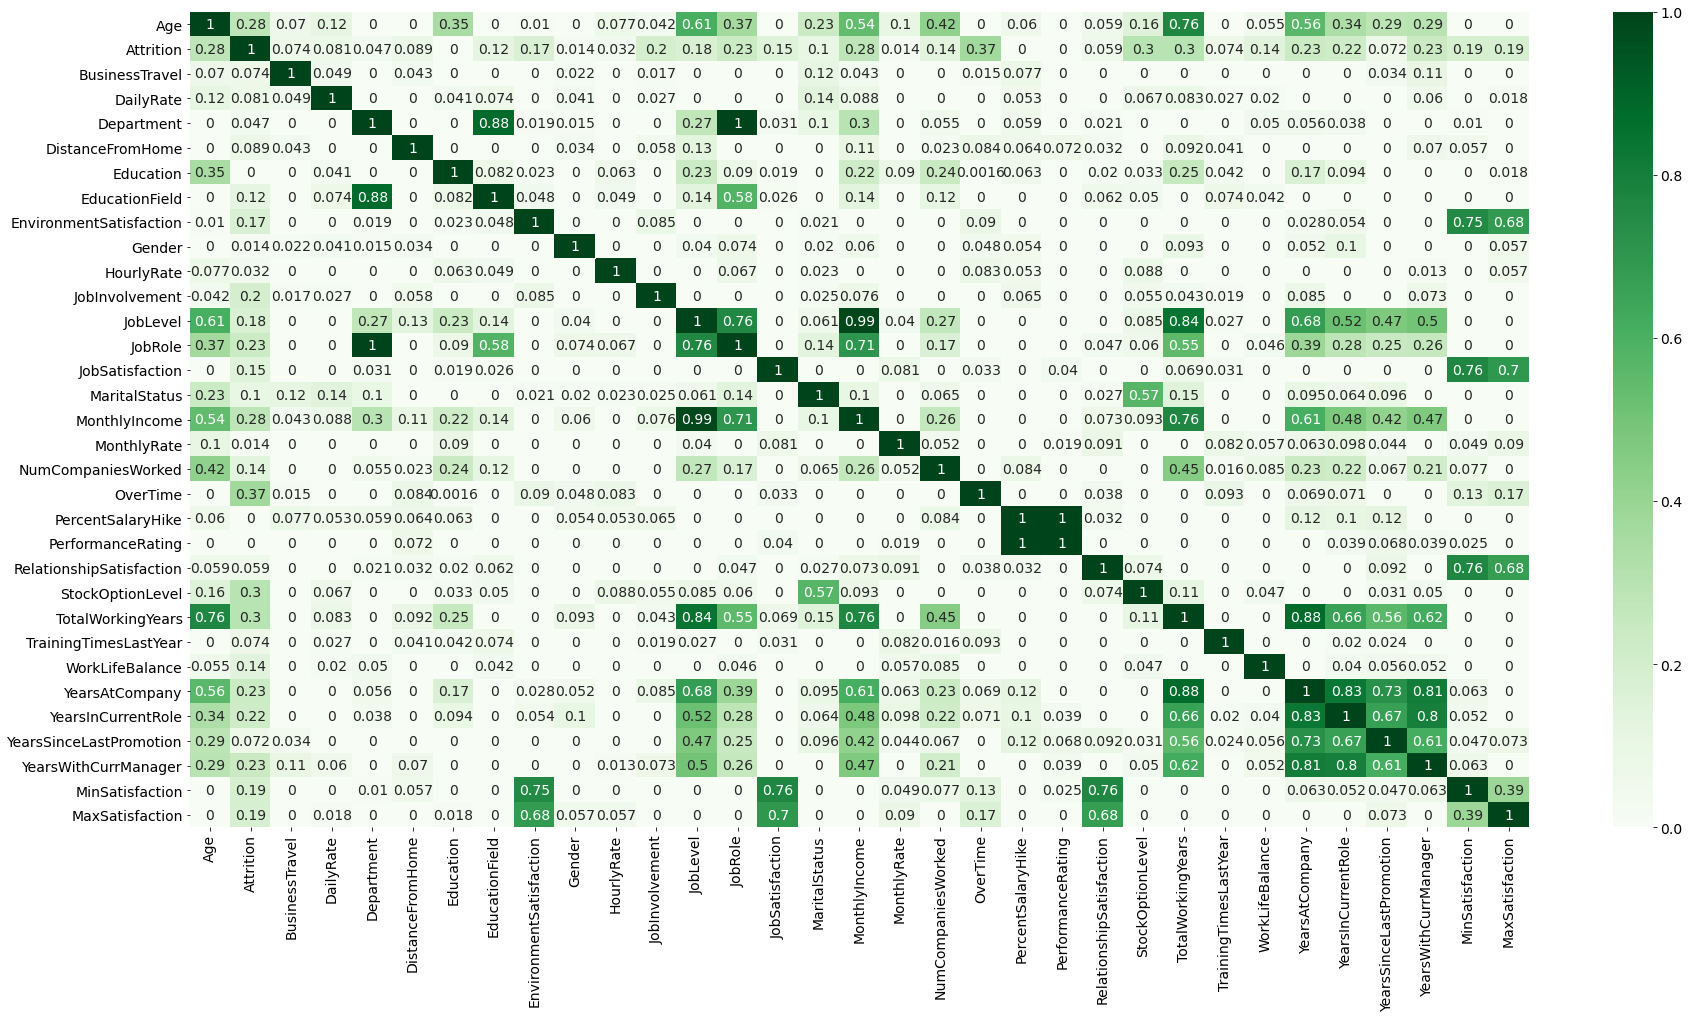

In [25]:
plt.figure(figsize=(30,15))
_ = sns.heatmap(corr, annot=True, cmap='Greens')

__Quais as variáveis mais relacionadas entre si?__

In [26]:
names = []
corr1 = []
corr2 = []

for x in corr.columns.tolist():
    corr1.append(x+' X '+corr[x].sort_values(ascending=False).drop(x).index[0])
    corr2.append(corr[x].sort_values(ascending=False).drop(x)[0])

best_corr = pd.DataFrame(list(zip(corr1,corr2)))
best_corr.columns = ['Variáveis', 'Correlação']
best_corr.set_index('Variáveis',inplace=True)
best_corr.drop_duplicates(inplace=True)
best_corr.sort_values('Correlação',ascending=False).T

Variáveis,PercentSalaryHike X PerformanceRating,Department X JobRole,JobLevel X MonthlyIncome,EducationField X Department,TotalWorkingYears X YearsAtCompany,YearsInCurrentRole X YearsAtCompany,YearsWithCurrManager X YearsAtCompany,Age X TotalWorkingYears,RelationshipSatisfaction X MinSatisfaction,JobSatisfaction X MinSatisfaction,EnvironmentSatisfaction X MinSatisfaction,YearsSinceLastPromotion X YearsAtCompany,MaxSatisfaction X JobSatisfaction,MaritalStatus X StockOptionLevel,NumCompaniesWorked X TotalWorkingYears,Attrition X OverTime,Education X Age,JobInvolvement X Attrition,WorkLifeBalance X Attrition,DailyRate X MaritalStatus,DistanceFromHome X JobLevel,BusinessTravel X MaritalStatus,Gender X YearsInCurrentRole,MonthlyRate X Age,TrainingTimesLastYear X OverTime,HourlyRate X StockOptionLevel
Correlação,1.0,0.997537,0.991277,0.880107,0.877913,0.83442,0.809624,0.764627,0.763825,0.762661,0.752677,0.729784,0.696051,0.572009,0.452953,0.372139,0.35204,0.198658,0.143809,0.141706,0.130732,0.115345,0.104878,0.102768,0.09294,0.087584


Vemos acima, por ordem decrescendente da esquerda para direita, a variáveis e maiores correlações respectivas. Abaixo fazemos algumas discussões para explorar melhor esses dados.

<a id='graficos'></a>

#### b. Gráficos

__PercentSalaryHike X PerformanceRating__

Interessante é perceber que há uma correlação de 100% entre as variáveis 'PercentSalaryHike' e 'PerformanceRating'. Abaixo fazemos um gráfico para entender melhor o motivo da correlação.

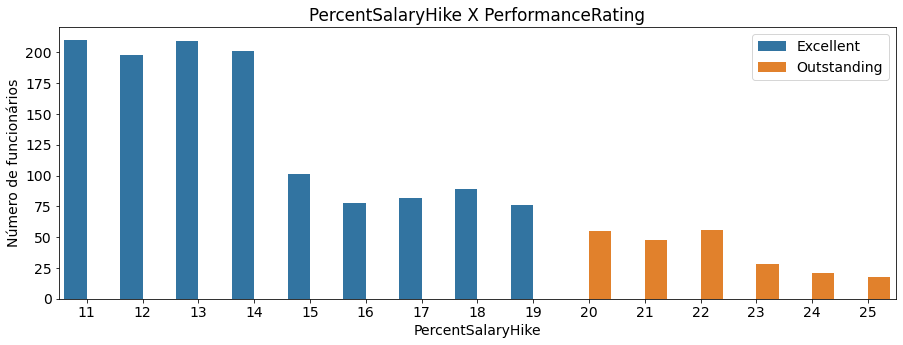

In [27]:
plt.subplots(figsize=(15,5))
sns.countplot(x='PercentSalaryHike',data=df,hue='PerformanceRating')
plt.legend(loc='upper right')
plt.title('PercentSalaryHike X PerformanceRating')
plt.ylabel('Número de funcionários')
plt.show()

É notável que para o 'PercentSalaryHike' (aumento salarial percentual) acima de 19, o 'PerformanceRating' será sempre igual a 4. Isso nos mostra que aumento salarial sempre irá implicar em aumento de performance.

__Department X JobRole__

Para entender como o departamento está relacionado à função, plotamos o gráfico abaixo:

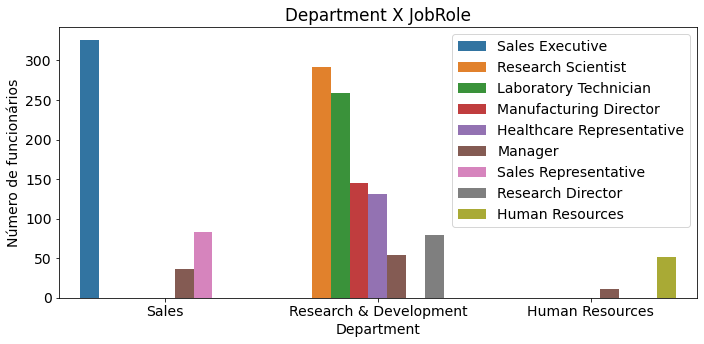

In [28]:
plt.subplots(figsize=(10,5))
sns.countplot(x='Department',data=df,hue='JobRole')
plt.legend(loc='upper right')
plt.title('Department X JobRole')
plt.ylabel('Número de funcionários')
plt.tight_layout()
plt.savefig('department_jobrole.jpeg')
plt.show()

Na empresa percebemos claramente as relações entre departamento e funções. "Sales Department" por exemplo, possui o "Sales Executive", cargo que somente pode estar relacionado ao departamento de sales. Em comum a todos os departamentos temos o "Manager", que é uma função de gestão, necessária a qualquer departamento obviamente. No departamento de "Research & Development" temos o maior número de funções, que incluem cientistas, técnicos, diretores, entre outros.

__JobLevel X MonthlyIncome__

Para entendermos como o salário e nível do cargo estão conectados, fazemos um boxplot para cada nível de cargo:

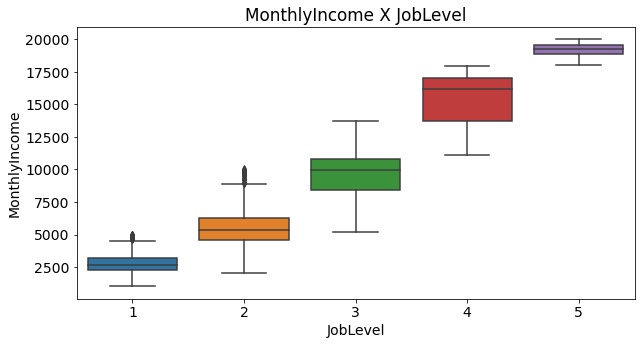

In [29]:
plt.subplots(figsize=(10,5))
sns.boxplot(y='MonthlyIncome',data=df,x='JobLevel')
plt.title('MonthlyIncome X JobLevel')
plt.ylabel('MonthlyIncome')
plt.show()

Percebemos que o "JobLevel" está diretamente relacionado com o "MonthlyIncome". Ou seja, quanto maior o nível na hierarquia da empresa, maior será também o salário do functionario, apesar de existirem situação em que funcionários com "JobLevel" 3, por exemplo, ganham mais do que funionários no "JobLevel" 4.

<a id='attrition'></a>

#### c. Attrition

Como "Attrition" é nossa variável alvo, reservei um espaço especial para ela, onde iremos fazer uma análise exploratória mais direcionada. Da descrição das variáveis categóricas, vemos também que a variável 'Attrition', que de fato é nosso alvo, está desbalanceada, pois das 1470 entradas, 1233 são 'No'.

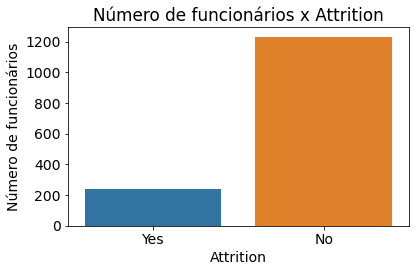

In [30]:
sns.countplot(x='Attrition',data=df)
plt.ylabel('Número de funcionários')
plt.title('Número de funcionários x Attrition')
plt.tight_layout()
plt.savefig('number_attrition.png')
plt.show()

Essa informação é de extrema importância quando formos construir o nosso modelo, pois a divisão entre treino e teste precisa ser representativa, do contrário teremos *sample bias*, além disso, a acurácia não será uma boa métrica para trabalharmos, justamente pelo desbalanceamento, recall, precision ou ROC-AUC são mais indicadas nesses casos, dependendo do tipo de problema encontrado. Para termos uma visão melhor da "Attrition", abaixo segue a correlação da mesma com as demais variáveis:

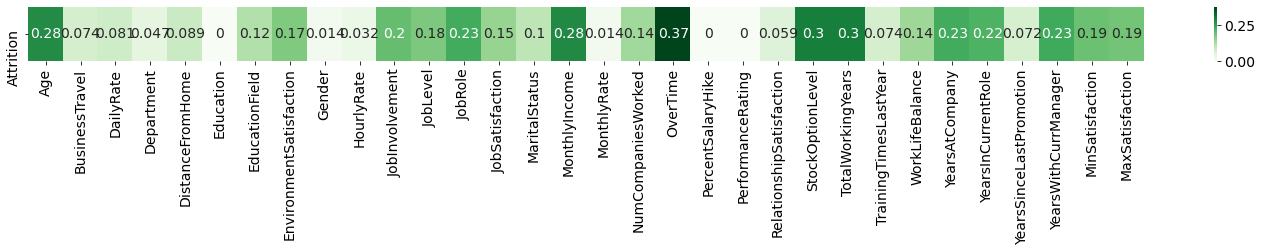

In [32]:
plt.figure(figsize=(25,1))
_ = sns.heatmap(corr[['Attrition']].drop('Attrition').T, annot=True, cmap='Greens')

Em orderm decrescente, a correlação das variáveis com a "Attrition" é dada por:

In [33]:
corr[['Attrition']].drop('Attrition').sort_values(by='Attrition',ascending=False)

,Attrition
OverTime,0.372139
TotalWorkingYears,0.297661
StockOptionLevel,0.297477
MonthlyIncome,0.280586
Age,0.278172
YearsWithCurrManager,0.234576
YearsAtCompany,0.232555
JobRole,0.231491
YearsInCurrentRole,0.220379
JobInvolvement,0.198658


Em seguida analisaremos algumas das variáveis considerando "Attrition".

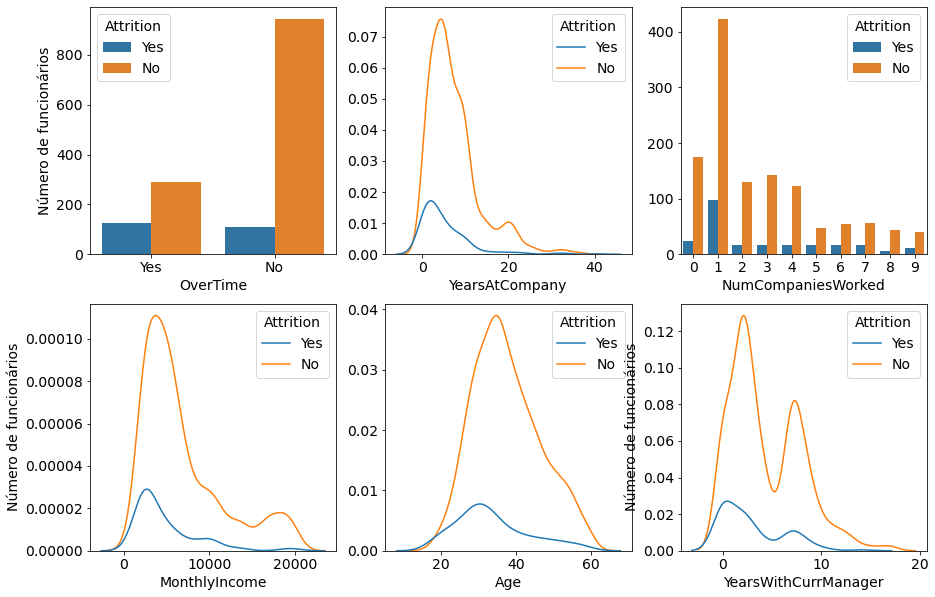

In [34]:
fig, ax = plt.subplots(nrows = 2, ncols=3, figsize = (15,10))

# Linha 0
sns.countplot(x='OverTime',hue='Attrition',data=df,ax=ax[0,0])
ax[0,0].set_ylabel('Número de funcionários')
sns.kdeplot(x='YearsAtCompany',hue='Attrition',data=df,ax=ax[0,1])
ax[0,1].set_ylabel(None)
sns.countplot(x='NumCompaniesWorked',hue='Attrition',data=df,ax=ax[0,2])
ax[0,2].set_ylabel(None)

# Linha 1

sns.kdeplot(x='MonthlyIncome',hue='Attrition',data=df,ax=ax[1,0])
ax[1,0].set_ylabel('Número de funcionários')
sns.kdeplot(x='Age',data=df,hue='Attrition',ax=ax[1,1])
ax[1,1].set_ylabel(None)
sns.kdeplot(x='YearsWithCurrManager',hue='Attrition',data=df,ax=ax[1,2])
ax[1,2].set_ylabel('Número de funcionários')

plt.show()

Acima plotamos alguns gráficos considerando 'Attrition'. Lembrando que os dados estão desbalanceados, podemos tirar as seguintes conclusões:

- A proporção de horas extras trabalhadas é maior entre os que deixaram a empresa, o que aparentemente pode ter causado deligamento do funcionário.

- Funcionários que pediram demissão tendem, naturalmente, a ficar menos tempo na empresa.

- Funcionários que pedem demissão geralmente não trabalharam muitas empresas, comparado aos que permanecem. O que pode ser algo relacinado à busca por novas experiências.

- Funcionários que pedem desligamento geralmente não possuem os maiores salários.

- Funcionários que pedem desligamento geralmente são mais novos.

- Aparentemente, após 5 anos, há uma transição de gerentes, de modo que apenas um percentual permaneça com o mesmo pelos próximos anos.

__Como a satisfação está relacionada ao desligamento dos funcionários?__

Como os dados estão desbalanceados, iremos analisar o nível de satisfação considerando a porcentagem das categorias dentro da classe dos desligados e dos que permaneceram na empresa. Assim podemos fazer um comparativo mais explícito dos dados. Para trabalhar esse ponto criamos a seguinte função:

In [35]:
def plot_perc(df,var):
    df_no = df[df['Attrition']=='No'].copy()
    df_yes = df[df['Attrition']=='Yes'].copy()
    df_new_no = pd.DataFrame(df_no[var].value_counts(normalize=True)).reset_index()
    df_new_no['Attrition']='No'
    df_new_yes = pd.DataFrame(df_yes[var].value_counts(normalize=True)).reset_index()
    df_new_yes['Attrition']='Yes'
    df_new = pd.concat([df_new_yes,df_new_no]).reset_index(drop=True)
    df_new.columns= [var,'Porcentagem','Attrition']

    plt.subplots(figsize=(10,5))
    sns.barplot(x=var,y='Porcentagem',data=df_new,hue='Attrition')
    plt.legend(loc='upper right')
    plt.title(var+' X Porcentagem')
    plt.ylabel('Porcentagem dentro do grupo')
    plt.show()

__JobSatisfaction__

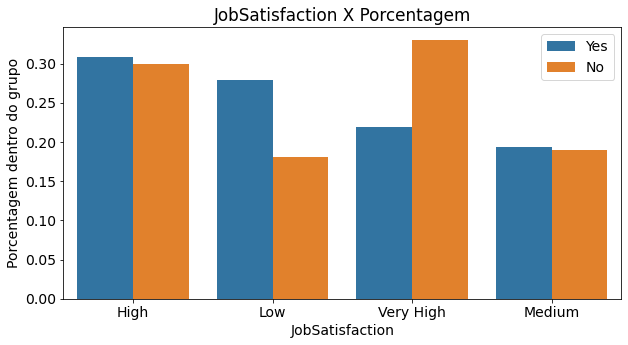

In [36]:
plot_perc(df,'JobSatisfaction')

Do gráfico acima retiramos as seguintes conclusões:

- Dentro do grupo dos que pediram demissão, a maior parte parte classificou a satisfação com o trabalho como alta, seguida de baixa, muito alta e média. O que é de certo modo supreendente, pois era de se esperar que os funcionários que possuissem baixa satisfação com o trabalho é que teriam maior participação no grupo de demitidos. Mas ainda assim, satisfação baixa é maior entre o grupo dos que pediram demissão do que entre os que permaneceram.

- No grupo dos que permaneceram na empresa, a ordem faz mais sentido, pois a satisfação de maior parte dos funcionários é muito alta, seguida de alta, média e baixa.

Aparentemente, satisfação com o trabalho não é um tão fator decisivo para desligamento do funcionário.

__RelationshipSatisfaction__

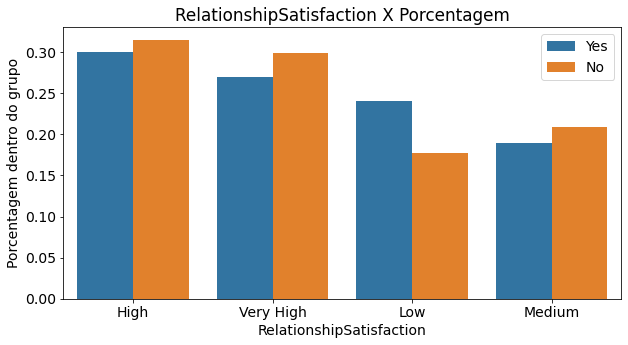

In [37]:
plot_perc(df,'RelationshipSatisfaction')

Entre os funcionários que pediram demissão, o relacionamento aparentemente não chegou a ser um fator decisivo, exceto quando baixo, onde a porcentagem de "Attrition" é maior entre os que pediram demissão em comparação aos que permaneceram.

__EnvironmentSatisfaction__

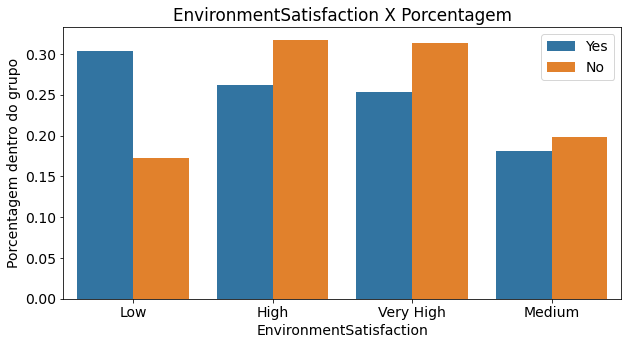

In [38]:
plot_perc(df,'EnvironmentSatisfaction')

Aqui percebemos algo importante e diferente do que vimos para a satisfação com trabalho e relacionamento. Há uma tendência de que, quanto menor a satisfação com o ambiente, maior o a porcentagem de funcionários que pedem demissão. Isso significa que os funcionários até se sentem satisfeitos com o trabalho e relacionamento com os demais, mas o ambiente não é muito favorável em certo casos, e pode causar o pedido de desligamento. Isso é de certo modo bom, pois melhorar o ambiente não é algo tão complicado (em comparação com relacionamento por exemplo), criando espaços de lazer, interação saudável, e colaboração ao invés de competição.

__Qual departamento tem maior porcentagem de "Attrition"?__

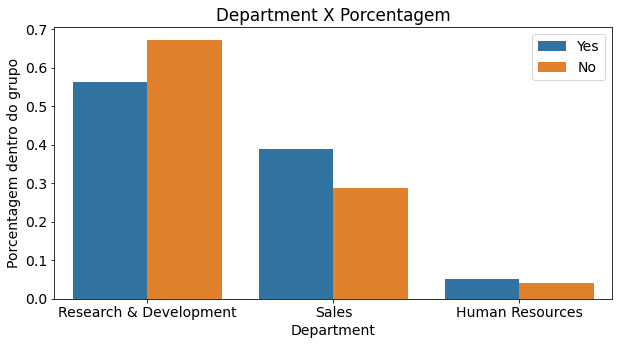

In [41]:
plot_perc(df,'Department')

Aqui percebemos que o departamento de Sales tem a maior porcentagem de grupo "Attrition". O que significa que é preciso ficar atento sobre os possíveis indicadores que possam afetar tal departamento. Em termos do departamento, também conseguimos tirar algumas conclusões sobre o salário dos funcionários:

C:\Users\pedre\anaconda3\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


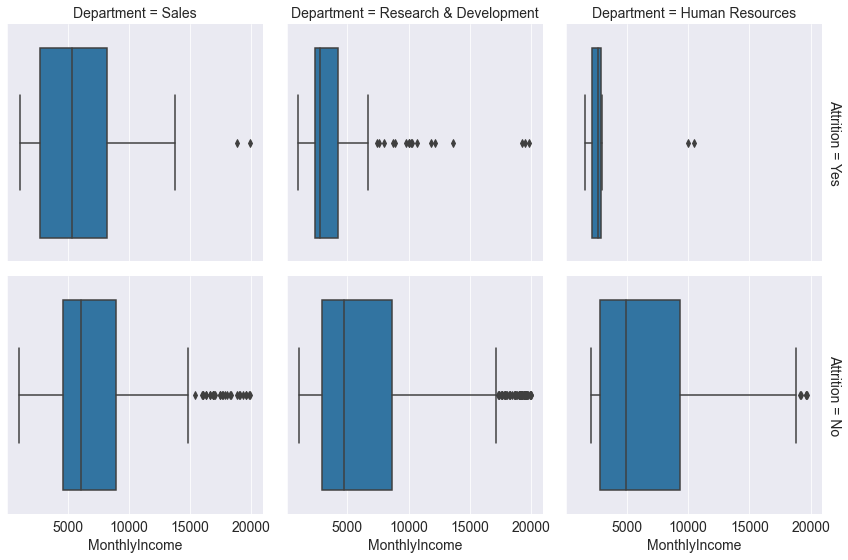

In [42]:
sns.set_style('darkgrid')
g = sns.FacetGrid(col='Department',row='Attrition',data=df,margin_titles=True,height=4)
g.map(sns.boxplot,'MonthlyIncome')
plt.show()

Aqui as conclusões que obtemos são:

- No departamento de Sales, os funcionários que pediram demissão recebiam menos que os que permaneceram na empresa.

- Em pesquisa e desenvolvimento, o salário possui uma distribuição similar entre os que permaneceram e pediram demissão. No entanto, salários mais altos são alcançados em sua maioria por aqueles que permanecem, o que se justifica por ser necessário mais tempo para alcançar tais cargos, e uma vez alcançados chega-se num patamar de satisfação.

- Funcionários dos recursos humanos tendem a receber menos entre os que pedem demissão.

Assim, percebemos que o salário é um fator relevante para continuidade do funcionário na empresa, principalmente no departamento de Sales e Recursos humanos.

<a id='modelagem'></a>

## 7. Modelagem

Após a análise que fizemos, seguimos para a modelagem, a fim de predizer quais funcionários tem maior risco de pedirem demissão.

<a id='processamento'></a>

### A. Pré-processamento

Na etapa de pré-processamento transformamos variáveis com duas saídas em 0 ou 1:

In [43]:
df_model = df.copy()
df_model['Attrition'] = df_model['Attrition'].replace(['Yes','No'],[1,0])
df_model['Gender'] = df_model['Gender'].replace(['Female','Male'],[1,0])
df_model['OverTime'] = df_model['OverTime'].replace(['Yes','No'],[1,0])
df_model['PerformanceRating'] = df_model['PerformanceRating'].replace(['Excellent','Outstanding'],[1,0])

Além de normalizar e fazer encoding nos dados e realizar a separação em treino e teste:

In [92]:
# Normalizador
MMS = MinMaxScaler()
# Dummies, encoding
dummies = pd.get_dummies(df_model.drop("Attrition",axis=1))
# Normalização
X = pd.DataFrame(MMS.fit_transform(dummies))
X.columns = dummies.columns
# Alvo
y = df_model["Attrition"]

# Separar em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 0, stratify=y)

Importante frizar que a separação em treino e teste está estratificada, ou seja, a porcentagem de "Attrition" dentro de treino e teste é igual.

<a id='modelos'></a>

### B. Testando modelos

Iremos testar alguns modelos, e o que melhor performar será nosso guia para as próximas melhorias.

__Naive Bayes__

In [93]:
model= GaussianNB()

cv = StratifiedKFold(n_splits = 5, shuffle = True)
result_gnb=cross_val_score(model,X_train,y_train,cv=cv,scoring='roc_auc')

print('O score de validação cruzada para o classificador Gaussian Naive Bayes é:',round(result_gnb.mean()*100,2),
      '\nCom máximo em', round(result_gnb.max()*100,2), 'e mínimo em ',round(result_gnb.min()*100,2))

O score de validação cruzada para o classificador Gaussian Naive Bayes é: 74.38 
Com máximo em 77.76 e mínimo em  71.22


__ElasticNet__

In [94]:
model = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=1,max_iter=1000)

cv = StratifiedKFold(n_splits = 5, shuffle = True)
result_reg=cross_val_score(model,X_train,y_train,cv=cv,scoring='roc_auc')

print('O score de validação cruzada para o classificador Logistic Regression (elasticnet) é:',round(result_reg.mean()*100,2),
      '\nCom máximo em', round(result_reg.max()*100,2), 'e mínimo em ',round(result_reg.min()*100,2))

O score de validação cruzada para o classificador Logistic Regression (elasticnet) é: 82.94 
Com máximo em 85.26 e mínimo em  79.21


__Tree Classifier__

In [95]:
model = DecisionTreeClassifier(max_depth=20,random_state=42)

cv = StratifiedKFold(n_splits = 5, shuffle = True)
result_tc=cross_val_score(model,X_train,y_train,cv=cv,scoring='roc_auc')

print('O score de validação cruzada para o classificador Decision Tree é:',round(result_tc.mean()*100,2),
      '\nCom máximo em', round(result_tc.max()*100,2), 'e mínimo em ',round(result_tc.min()*100,2))

O score de validação cruzada para o classificador Decision Tree é: 59.22 
Com máximo em 60.39 e mínimo em  56.86


__Random Forest__

In [96]:
model = RandomForestClassifier(criterion='gini', n_estimators=20,
                             min_samples_split=2,min_samples_leaf=10,
                             max_features='auto',oob_score=True,
                             random_state=42,max_depth=5,n_jobs=-1)

cv = StratifiedKFold(n_splits = 5, shuffle = True)
result_rf=cross_val_score(model,X_train,y_train,cv=cv,scoring='roc_auc')

print('O score de validação cruzada para o classificador Random Forest é:',round(result_rf.mean()*100,2),
      '\nCom máximo em', round(result_rf.max()*100,2), 'e mínimo em ',round(result_rf.min()*100,2))

O score de validação cruzada para o classificador Random Forest é: 78.47 
Com máximo em 83.08 e mínimo em  71.77


__Light GBM__

In [97]:
model = lgb.LGBMClassifier(n_estimators=100, random_state=42,max_depth=5,n_jobs=-1,num_leaves=10)

cv = StratifiedKFold(n_splits = 5, shuffle = True)
result_gbm=cross_val_score(model,X_train,y_train,cv=cv,scoring='roc_auc')

print('O score de validação cruzada para o classificador LGBM é:',round(result_gbm.mean()*100,2),
      '\nCom máximo em', round(result_gbm.max()*100,2), 'e mínimo em ',round(result_gbm.min()*100,2))

O score de validação cruzada para o classificador LGBM é: 80.76 
Com máximo em 84.02 e mínimo em  75.71


O modelo que melhor performou melhor na média foi a regressão logística, portanto ele será selacionado para os próximos passos.

<a id='selecao'></a>

### C. Seleção de variáveis

Para iniciarmos a optimização, selecionaremos a quantidade ideal de features para o modelo utilizando o Recursive Features:

número ótimo de features : 39


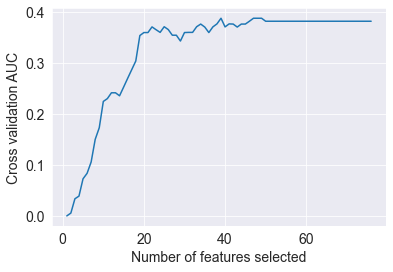

In [129]:
logistic = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=1,max_iter=1000,random_state=10)
rfecv = RFECV(estimator=logistic, step=1, cv=10, scoring='recall',n_jobs=-1)

rfecv.fit(X_train, y_train)

print("número ótimo de features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation AUC")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

<a id='importancia'></a>

### D. Importância das variáveis

Sendo 39 o melhor número de features, plotamos abaixo o podemos entender com "importância das variáveis", mas que de fato são os coeficientes da regressão.

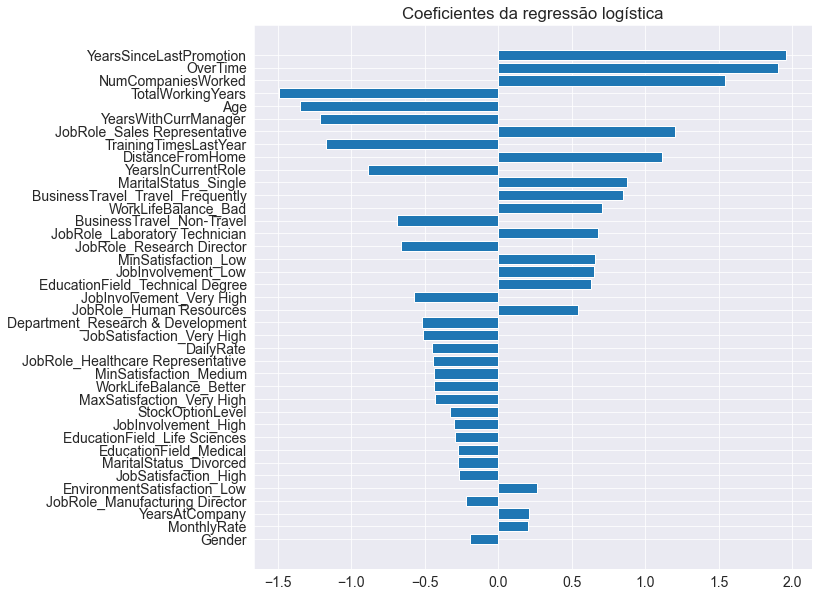

In [130]:
plt.subplots(figsize=(10,10))
logistic.fit(X_train, y_train)
importance = pd.DataFrame(zip(dummies.columns,logistic.coef_[0]))
importance.columns = ['features','score']
importance['Absolute'] = np.abs(importance['score'])
importance = importance.sort_values(by='Absolute',ascending=True).reset_index(drop=True)
plt.barh(importance['features'][-39:], importance['score'][-39:])
plt.title('Coeficientes da regressão logística')
plt.show()

Escolhemos as features mais importantes:

In [131]:
most_important = importance['features'][-39:]

E calculamos novamente o score:

In [132]:
model = LogisticRegression(penalty='elasticnet',solver='saga',l1_ratio=1,max_iter=1000)

cv = StratifiedKFold(n_splits = 5, shuffle = True)
result_reg=cross_val_score(model,X_train[most_important],y_train,cv=cv,scoring='roc_auc')

print('O score de validação cruzada para o classificador Logistic Regression (elasticnet) é:',round(result_reg.mean()*100,2),
      '\nCom máximo em', round(result_reg.max()*100,2), 'e mínimo em ',round(result_reg.min()*100,2))

O score de validação cruzada para o classificador Logistic Regression (elasticnet) é: 83.72 
Com máximo em 88.06 e mínimo em  77.64


Percebemos que houve um aumento, o que é algo bom.

<a id='gridSearch'></a>

### E. GridSearch

Em seguida, optimizamos os hiper-parâmetros do modelo utilizando um Grid Search:

In [133]:
model = LogisticRegression(penalty='elasticnet',solver='saga',max_iter=10000)

params = {'C' : [0.5,1,2,3],
          'l1_ratio' : [None,0.01,0.1,0.5,1],
          'class_weight': ['balanced',None]
         }

cv = StratifiedKFold(n_splits = 10, shuffle = True)

grid_search = GridSearchCV(estimator = model,
                           param_grid = params,
                           scoring = 'recall',
                           cv = cv,
                           n_jobs = -1)

grid_search = grid_search.fit(X_train[most_important], y_train)

Escolhemos o recall para optimização pois é importante acertamos o maior número possível dentro de todos o que pedem demissão. Os melhores parâmetro e o melhor score é dado por:

In [134]:
best_roc = grid_search.best_score_
best_parameters = grid_search.best_params_
print("Best Accuracy: {:.2f} %".format(best_roc*100))
print("Best Parameters:", best_parameters)

Best Accuracy: 74.64 %
Best Parameters: {'C': 0.5, 'class_weight': 'balanced', 'l1_ratio': 0.01}


Assim, nosso modelo fica definido como:

In [135]:
log_reg_model = LogisticRegression(penalty='elasticnet',solver='saga',
                                   max_iter=10000,C=0.5, l1_ratio=0.01, class_weight= 'balanced')
log_reg_model.fit(X_train[most_important], y_train)

LogisticRegression(C=0.5, class_weight='balanced', l1_ratio=0.01,
                   max_iter=10000, penalty='elasticnet', solver='saga')

<a id='metricas'></a>

### F. Métricas

Abaixo, calculamos algumas métricas

__ROC-AUC__

In [136]:
y_pred = log_reg_model.predict(X_test[most_important])
print("Model accruracy score: {}".format(roc_auc_score(y_test, y_pred)))

Model accruracy score: 0.7548406560254511


__Precision, Recall, Acurácia__

Base de treino

In [137]:
print(classification_report(y_train, log_reg_model.predict(X_train[most_important])))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86       924
           1       0.42      0.83      0.56       178

    accuracy                           0.79      1102
   macro avg       0.69      0.81      0.71      1102
weighted avg       0.87      0.79      0.81      1102



Base de teste

In [138]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.83      0.88       309
           1       0.43      0.68      0.53        59

    accuracy                           0.81       368
   macro avg       0.68      0.75      0.70       368
weighted avg       0.85      0.81      0.82       368



Aparentemente não há overfit, o que é um bom sinal.

__Curva ROC__

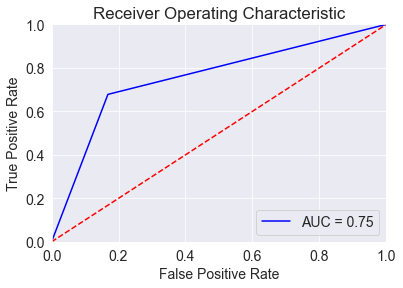

In [139]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Consideramos modelo bom, que pode ser melhorado, mas que já nos dá uma boa previsão em termos de "Attrition".

__Matriz de confusão__

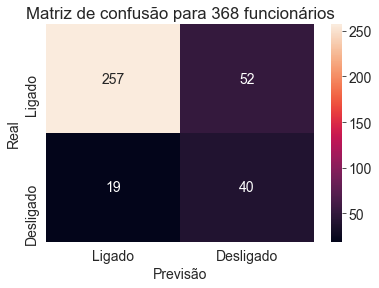

In [154]:
cm = confusion_matrix(y_true = y_test, y_pred = y_pred)    

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax,fmt='g'); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Previsão');ax.set_ylabel('Real'); 
ax.set_title('Matriz de confusão para '+str(len(y_test))+' funcionários'); 
ax.xaxis.set_ticklabels(['Ligado', 'Desligado']); ax.yaxis.set_ticklabels(['Ligado', 'Desligado']);

Dos 59 funcionários que foram desligados, conseguimos acertar 40, onde algo poderia ser feito para reverter a situação.

<a id='distribuicao'></a>

### G. Distribuição

Abaixo plotamos a distribuição de score para "Atrition".

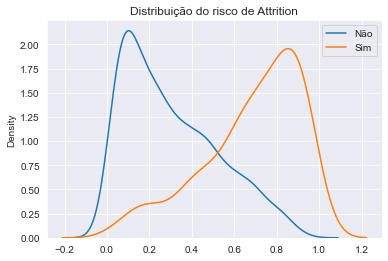

In [492]:
y_predall = log_reg_model.predict_proba(X[most_important])
sns.kdeplot(y_predall[:,1][y == 0])
sns.kdeplot(y_predall[:,1][y == 1])
plt.legend(['Não','Sim'])
plt.title('Distribuição do risco de Attrition')
plt.show()

<a id='risco'></a>

## H. Grupos de risco

Para melhor serem trabalhadas a ações de retenção de funcionários, iremos dividir as probabilidades em grupos. Primeiramente, criamos um dataframe com previsões e "Attrition":

In [481]:
riskNo = y_predall[:,0].tolist()
riskYes = y_predall[:,1].tolist()
Attrition = y
risk = pd.DataFrame(list(zip(riskNo,riskYes,Attrition)),columns=['riskNo','riskYes','Attrition'])
risk.head()

,riskNo,riskYes,Attrition
0,0.113632,0.886368,1
1,0.900589,0.099411,0
2,0.204510,0.795490,1
3,0.662121,0.337879,0
4,0.331106,0.668894,0


Em seguida dividimos os grupos utiizando a função qcut:

In [486]:
pd.qcut(risk['riskNo'], q=5)

0       (0.0091, 0.372]
1        (0.892, 0.997]
2       (0.0091, 0.372]
3         (0.597, 0.77]
4       (0.0091, 0.372]
             ...       
1465      (0.77, 0.892]
1466      (0.77, 0.892]
1467     (0.372, 0.597]
1468      (0.77, 0.892]
1469      (0.597, 0.77]
Name: riskNo, Length: 1470, dtype: category
Categories (5, interval[float64]): [(0.0091, 0.372] < (0.372, 0.597] < (0.597, 0.77] < (0.77, 0.892] < (0.892, 0.997]]

Depois criamos os grupos de risco:

In [487]:
for x in risk['riskNo'].unique():
    if x<0.372:
        risk.loc[risk['riskNo']==x,'Grupo de Risco']='E'
    elif x>=0.372 and x<0.597:
        risk.loc[risk['riskNo']==x,'Grupo de Risco']='D'
    elif x>=0.597 and x<0.77:
        risk.loc[risk['riskNo']==x,'Grupo de Risco']='C'
    elif x>=0.77 and x<0.892:
        risk.loc[risk['riskNo']==x,'Grupo de Risco']='B'
    else:
        risk.loc[risk['riskNo']==x,'Grupo de Risco']='A'

Cuja distribuição será igual:

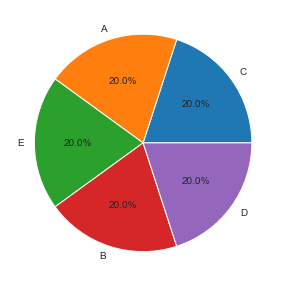

In [488]:
plt.subplots(figsize=(5,5))
labels = risk['Grupo de Risco'].value_counts(normalize=True).index.tolist()
plt.pie(risk['Grupo de Risco'].value_counts().tolist(),labels=labels,autopct='%1.1f%%')
plt.show()

Após isso, vemos abaixo a porcentagem de "Attrition" em cada grupo:

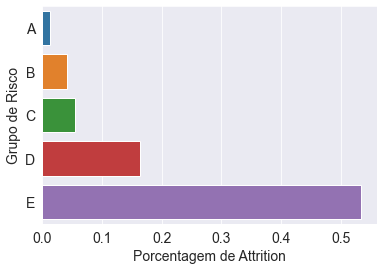

In [628]:
risk_dist = risk.groupby('Grupo de Risco')['Attrition'].sum()/risk.groupby('Grupo de Risco')['Grupo de Risco'].count()
sns.barplot(x=risk_dist.values,y=risk_dist.index)
plt.xlabel('Porcentagem de Attrition')
plt.show()

Grupos D e E merecem bastande atenção. Ou seja, ao se chegar no grupo há probabilidade de mais de 50% do funcionário pedir demissão.

<a id='explicabilidade'></a>

### I. Explicabilidade do modelo

Em termos de motivos para demissão, abaixo segue uma análise de importância:

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


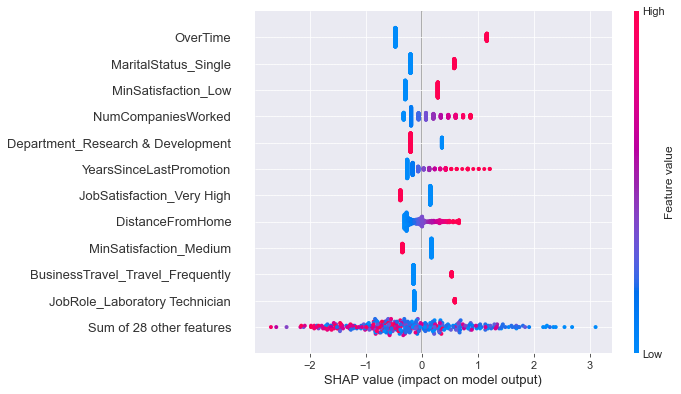

In [155]:
import shap
explainer = shap.Explainer(log_reg_model,X_train[most_important],feature_names=X.columns)
shap_values = explainer(X_test[most_important])
shap.plots.beeswarm(shap_values, max_display=12)

Plotamos acima as 12 variáveis mais importantes e como elas estão relacionadas ao modelo. Em geral, quanto maior o valor da variável (quanto mais vermelha), maior será a relevância para o modelo, ou seja, maior será seu impacto, tanto para valores negativos ou positivos de SHAP value.

<a id='conclusao'></a>

## 8. Conclusões e perspectivas

O presente projeto teve como objetivo analisar dados de uma empresa a fim de identificar fatores que possam afetar a quantidade de pedidos de demissão. Essa podem implicar em diminuição de gastos para contratação, melhoria na qualidade do trabalho e ambiente da empresa, assim como motivar amaior produção dos funcionários.

Desenvolvemos um modelo com poder de predição de 75 %, o que pode ser considerado um modelo bom. Além de ser estável, sem overfit, com a devida regularização, visando sempre aumentar a taxa de acerto.

Como melhorias ao projeto sugeriria uma análise mais aprofundada de outliers, assim como teste de outros modelos e correspondente tunagem de hiperparâmetros.